In [1]:
import pandas as pd

df = pd.read_csv("data/Davos_combined_clean.csv")
df.head()


,price_raw,type,distance_zentrum_meters,distance_skilift_meters,zimmer_description,zimmer_typ,zimmer_count,has_balkon
0,411,ferienwohnung,800,100,Apartment mit Blick auf die Berge,apartment,1,False
1,134,ferienwohnung,900,600,Comfort Studio (2 Erwachsene),studio,1,False
2,120,ferienwohnung,1400,1200,Zweibettzimmer,zimmer,1,False
3,199,ferienwohnung,800,300,Standard Doppelzimmer,zimmer,1,False
4,285,ferienwohnung,1200,100,Executive Doppelzimmer,zimmer,1,False


#Zielvariabel festlegen

In [2]:
y = df["price_raw"]


#Erklärende Variablen festlegen

In [3]:
X = df[
    [
        "distance_zentrum_meters",
        "distance_skilift_meters",
        "zimmer_count"
    ]
]

#Kurze Kontrolle, dass nur int64 vorhanden ist:

In [4]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   distance_zentrum_meters  81 non-null     int64
 1   distance_skilift_meters  81 non-null     int64
 2   zimmer_count             81 non-null     int64
dtypes: int64(3)
memory usage: 2.0 KB


#Train-Test-Split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


#Regression Tree erstellen

In [6]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(
    max_depth=3,          # begrenzt Komplexität
    min_samples_leaf=10,  # verhindert Overfitting
    random_state=42
)

tree.fit(X_train, y_train)


,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


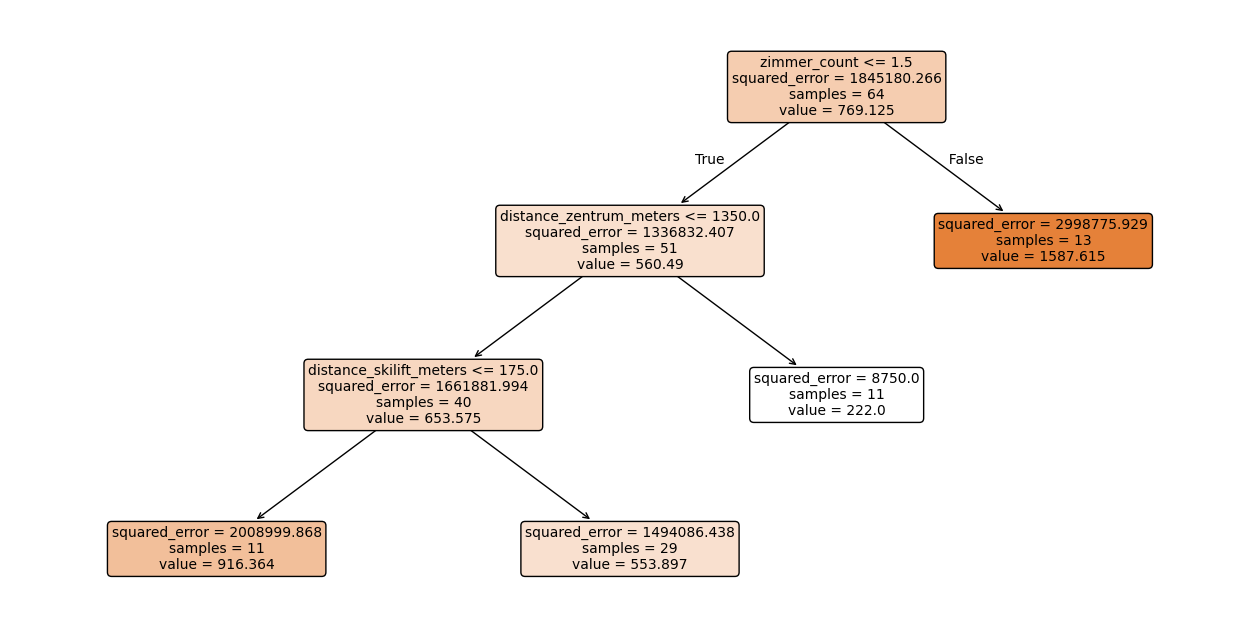

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plot_tree(
    tree,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()


#Overfitting DEMO: Der Baum wird bewusst zu gross gemacht

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree_overfit = DecisionTreeRegressor(
    max_depth=6,          # absichtlich tief
    min_samples_leaf=1,  # absichtlich klein
    random_state=42
)

tree_overfit.fit(X_train, y_train)


,criterion,'squared_error'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [9]:
r2_train = tree_overfit.score(X_train, y_train)
r2_test  = tree_overfit.score(X_test, y_test)

r2_train, r2_test



(0.9558723025925973, 0.3875817209960486)

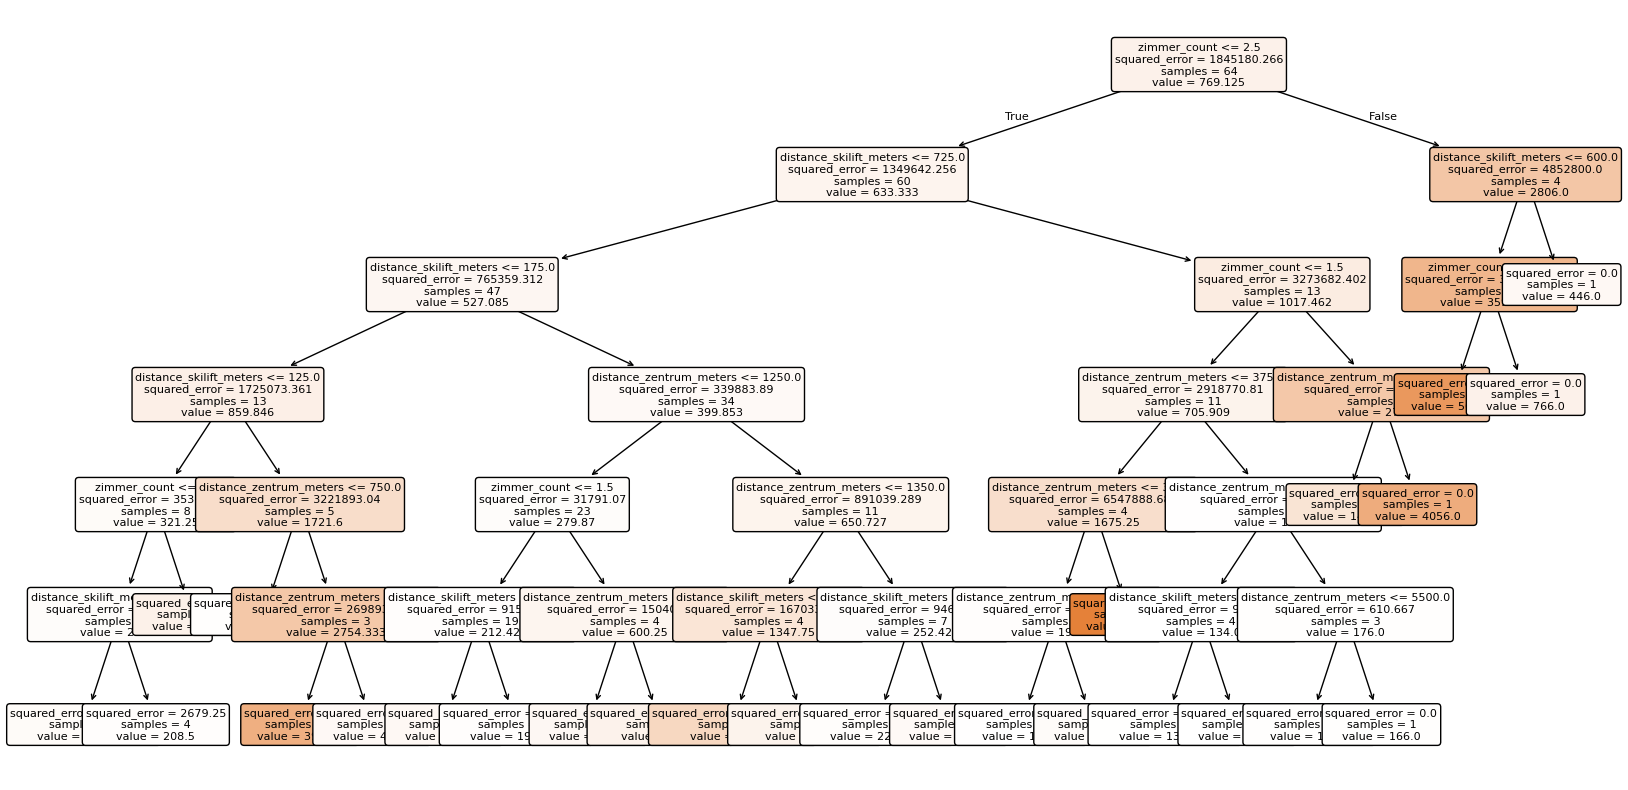

In [10]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    tree_overfit,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()


#Pruning by Regression Trees

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_pruned = DecisionTreeRegressor(
    max_depth=3,
    min_samples_leaf=10,
    random_state=42
)

tree_pruned.fit(X_train, y_train)
tree_pruned.score(X_test, y_test)



0.10485885562833686

In [12]:
df["has_balkon"].value_counts()


has_balkon
False    72
True      9
Name: count, dtype: int64

In [13]:
df["has_balkon"] = df["has_balkon"].astype(int)


In [14]:
X = df[
    [
        "distance_zentrum_meters",
        "distance_skilift_meters",
        "zimmer_count",
        "has_balkon"
    ]
]


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


In [16]:
from sklearn.tree import DecisionTreeRegressor

tree_balcony = DecisionTreeRegressor(
    max_depth=3,
    min_samples_leaf=10,
    random_state=42
)

tree_balcony.fit(X_train, y_train)


,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [17]:
r2_balcony = tree_balcony.score(X_test, y_test)
r2_balcony


0.10485885562833686

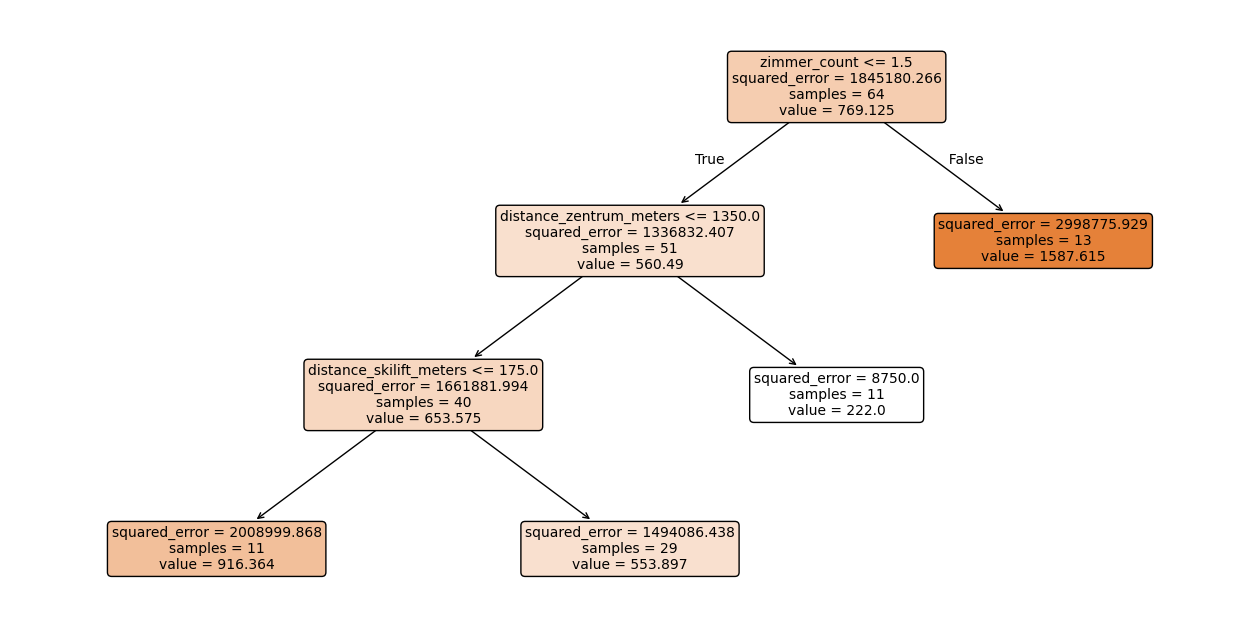

In [18]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plot_tree(
    tree_balcony,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()


## One-Way ANOVA: Price_raw by Accommodation Type


In [19]:
# Relevante Spalten auswählen
anova_df = df[["price_raw", "type"]].copy()

# Einheitliche Schreibweise
anova_df["type"] = anova_df["type"].str.lower().str.strip()

# Nur hotel & ferienwohnung behalten
anova_df = anova_df[anova_df["type"].isin(["hotel", "ferienwohnung"])]

# price_raw sicher numerisch
anova_df["price_raw"] = pd.to_numeric(anova_df["price_raw"], errors="coerce")

# Fehlende Werte entfernen
anova_df = anova_df.dropna()

anova_df["type"].value_counts()


type
hotel            47
ferienwohnung    34
Name: count, dtype: int64

In [20]:
anova_df.groupby("type")["price_raw"].agg(["count", "mean", "std", "median"])


,count,mean,std,median
type,,,,
ferienwohnung,34,1151.558824,1591.736924,438.5
hotel,47,522.936170,1033.967820,210.0


In [21]:
from scipy import stats

hotel_prices = anova_df.loc[anova_df["type"] == "hotel", "price_raw"]
fw_prices = anova_df.loc[anova_df["type"] == "ferienwohnung", "price_raw"]

F_stat, p_value = stats.f_oneway(hotel_prices, fw_prices)

print(f"F-statistic: {F_stat:.4f}")
print(f"p-value: {p_value:.6f}")


F-statistic: 4.6381
p-value: 0.034319


In [22]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("price_raw ~ C(type)", data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
C(type),7.796000e+06,1.0,4.638107,0.034319
Residual,1.327878e+08,79.0,NaN,NaN


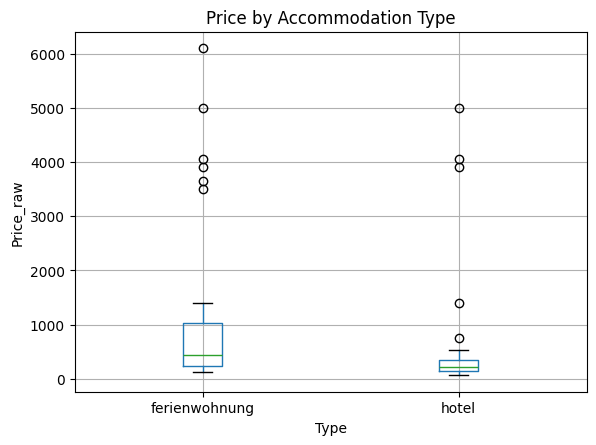

In [23]:
import matplotlib.pyplot as plt

anova_df.boxplot(column="price_raw", by="type")
plt.title("Price by Accommodation Type")
plt.suptitle("")
plt.xlabel("Type")
plt.ylabel("Price_raw")
plt.show()
